# Who Does my Baby Look Like? A Machine Learning's Answer to Family Resemblance

## Objective
The goal of this project is to provide my newborn baby's picture and see what the trained model thinks about the picture—does the baby resemble me more or my wife? Sure, friends and family have their opinions, but why leave such an important question to chance (or my sister's biased eye)?

By leveraging the power of **deep learning** and **facial recognition**, I’ll train a neural network to settle the debate once and for all: is the baby a mini-me or more of a mama’s look-alike? We'll take the science of face recognition into the exciting world of family resemblance.

### Here's the Plan:
- **Step 0**: Collect the data the model will be trained on.
- **Step 1**: Train a basic CNN model to distinguish between my face and my wife’s face.
- **Step 2**: Use this model to analyze our baby's features and decide who the baby takes after. - Plot the distribution of scores (under 0.5 means he resembles me, over 0.5 means he resembles my wife).
- **Step 3**: See how the pictures cluster. - Using Kmeans clustering.
---- 
(optional)
- **Step 4**: Expand the training dataset to include the pictures of the baby's maternal and paternal grand parents and see if the baby resembles them more than me and my wife. 

Will our baby’s face an equal blend me and my wife's faces or a carbon copy of one parent? Perhaps he will resemble his grandparent more? Let's hear what the algorithm has to say.

# Step 0: Collect the data the model will be trained on.

- Retrieving of the faces using Google Photos API is written in a [separate notebook](./data_acquisition.ipynb).

# Step 1: Train a basic CNN model to distinguish between my face and my wife’s face.

In [2]:
# Import all the necessary libraries
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torch.utils.data import random_split, DataLoader 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets


In [3]:
import random

# Set the random seed for Python's random module
random.seed(42)

# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.

# For deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Define a basic CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Becomes 32x75x75
        x = self.pool(F.relu(self.conv2(x))) # Becomes 64x38x38
        x = self.pool(F.relu(self.conv3(x))) # Becomes 128x18x18
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### Calculating Mean and Standard Deviation of Images

We need to calculate the mean and standard deviation of the images in our dataset to standardize the images.

In [6]:
# Function to calculate mean and standard deviation of images
def calculate_mean_std(folder_path):
    pixel_values = []

    for subfolder in os.listdir(folder_path):
        for filename in os.listdir(os.path.join(folder_path, subfolder)):
            img_path = os.path.join(folder_path, subfolder, filename)
            img = Image.open(img_path).convert('RGB')
            img = np.array(img)
            pixel_values.append(img)

    pixel_values = np.concatenate([img.reshape(-1, 3) for img in pixel_values], axis=0)
    mean = np.mean(pixel_values, axis=0) / 255
    std = np.std(pixel_values, axis=0) / 255

    return mean, std

In [7]:
# The trainig data will be pictures of my wife and I.
class_names = ['wife', 'husband']

# Set the folder path
folder_path = './train_data'

# Calculate the mean and std of the dataset
mean, std = calculate_mean_std(folder_path)
mean, std

(array([0.55169031, 0.41062668, 0.3543656 ]),
 array([0.23838194, 0.21149596, 0.20499264]))

In [8]:
# Define a data composer 
normalizer = Normalize(mean, std)
composer = Compose([Resize((150, 150)), ToTensor(), normalizer])

# Load the dataset and split it into training and validation sets
dataset = ImageFolder(root=folder_path, transform=composer)
# Calculate the number of samples for training and validation based on the split ratio
train_val_split_ratio = 0.7
n_train = int(len(dataset) * train_val_split_ratio)
n_val = len(dataset) - n_train

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training of the model (with displaying training and validation loss, and the trained model's accuracy)

In [10]:
# Send model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device for training: {device}")
model = SimpleCNN().to(device)

# Initialize the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}', end=', ')

    # Estimate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f'Validation Loss: {val_loss/len(val_loader)}')

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Epoch 1/10, Training Loss: 0.5625946040336902, Validation Loss: 0.46422877365892584
Epoch 2/10, Training Loss: 0.3561800451805958, Validation Loss: 0.3638305203481154
Epoch 3/10, Training Loss: 0.25902209459589076, Validation Loss: 0.3066866844892502
Epoch 4/10, Training Loss: 0.20017369764928633, Validation Loss: 0.27111227133057336
Epoch 5/10, Training Loss: 0.16910146950529173, Validation Loss: 0.339369998736815
Epoch 6/10, Training Loss: 0.08533507818356156, Validation Loss: 0.3868498070673509
Epoch 7/10, Training Loss: 0.048761822131032556, Validation Loss: 0.4440610788085244
Epoch 8/10, Training Loss: 0.045025457216140166, Validation Loss: 0.3802278631112792
Epoch 9/10, Training Loss: 0.016995950263942808, Validation Loss: 0.44244636595249176
Epoch 10/10, Training Loss: 0.00834265797255704, Validation Loss: 0.45195193791931326
Validation Accuracy: 91.35%


In [11]:
device

device(type='cpu')

That's pretty good, but it seems overfitting.
One of the ways you can avoid overfitting is early-stopping. Let's implement that.

In [12]:
# Early stopping parameters
patience = 2
best_loss = float('inf')
patience_counter = 0

# Set the random seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.

# Initialize the model and optimizer
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.float().unsqueeze(1).to(device)  # Send data and target to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)  # Send data and target to GPU
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Training Loss: 0.5438625376958114, Validation Loss: 0.47180772640488366
Epoch 2, Training Loss: 0.39369437671624696, Validation Loss: 0.40031516416506335
Epoch 3, Training Loss: 0.3201777496590064, Validation Loss: 0.33905235068364575
Epoch 4, Training Loss: 0.22982841156996214, Validation Loss: 0.3160758763551712
Epoch 5, Training Loss: 0.17531366295252854, Validation Loss: 0.28637524761936883
Epoch 6, Training Loss: 0.1645601328748923, Validation Loss: 0.26522989300164307
Epoch 7, Training Loss: 0.11921059827391918, Validation Loss: 0.2594442218542099
Epoch 8, Training Loss: 0.11457275799833812, Validation Loss: 0.29387290504845703
Epoch 9, Training Loss: 0.10704824672295497, Validation Loss: 0.2828637090596286
Early stopping triggered


Let's add some data augmentation.

In [14]:
from torch.utils.data import Subset 

# Define data augmentation transforms suitable for face images
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define transforms for the validation dataset (usually just normalization)
val_transforms = transforms.Compose([
    Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset and split it into training and validation sets
dataset = ImageFolder(root=folder_path, transform=composer)
# Calculate the number of samples for training and validation based on the split ratio
train_val_split_ratio = 0.7
n_train = int(len(dataset) * train_val_split_ratio)
n_val = len(dataset) - n_train

# Split the dataset into training and validation subsets
train_indices, val_indices = random_split(range(len(dataset)), [n_train, n_val])

# Create new datasets from the subsets with the appropriate transforms
train_dataset = Subset(dataset, train_indices)
train_dataset.dataset.transform = train_transforms

val_dataset = Subset(dataset, val_indices)
val_dataset.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Let's also increase the number of epochs.

In [15]:
# Early stopping parameters
patience = 2
best_loss = float('inf')
patience_counter = 0

# Set the random seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.

# Initialize the model and optimizer
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(20):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.float().unsqueeze(1).to(device)  # Send data and target to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)  # Send data and target to GPU
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Epoch 1, Training Loss: 0.5585883133686506, Validation Loss: 0.4242624315348538
Epoch 2, Training Loss: 0.40197882743982166, Validation Loss: 0.316085856069218
Epoch 3, Training Loss: 0.3305908005971175, Validation Loss: 0.26782250810753216
Epoch 4, Training Loss: 0.24998877827937788, Validation Loss: 0.21365858953107486
Epoch 5, Training Loss: 0.2000666667635624, Validation Loss: 0.18065967952663248
Epoch 6, Training Loss: 0.16788122774316713, Validation Loss: 0.1850262169133533
Epoch 7, Training Loss: 0.13802220149395558, Validation Loss: 0.15626532652161337
Epoch 8, Training Loss: 0.11609397083520889, Validation Loss: 0.1576735617762262
Epoch 9, Training Loss: 0.10334678825277549, Validation Loss: 0.14182585274631326
Epoch 10, Training Loss: 0.0849423328987681, Validation Loss: 0.1355517960407517
Epoch 11, Training Loss: 0.07231186423450708, Validation Loss: 0.1263989701189778
Epoch 12, Training Loss: 0.08055661711841822, Validation Loss: 0.1483038453893228
Epoch 13, Training Loss: 

# Step 2: Use this model to analyze our baby's features and decide who the baby takes after. - Plot the distribution of scores (under 0.5 means he resembles me, over 0.5 means he resembles my wife).

## Visualize individual predictions of the model

In this section, we will display the prediction results of our trained model. We will use the `display_image_and_prediction` function to show the image of the baby along with the model's prediction of whether the baby resembles the wife or the husband.

The `display_image_and_prediction` function takes an image path as input, processes the image using the `composer` transform, and then uses the trained `model` to predict the resemblance. The result is displayed using `matplotlib`.

To navigate through multiple images, we have implemented a button functionality that allows us to view the next image in the folder.

Here is the code to display the prediction:

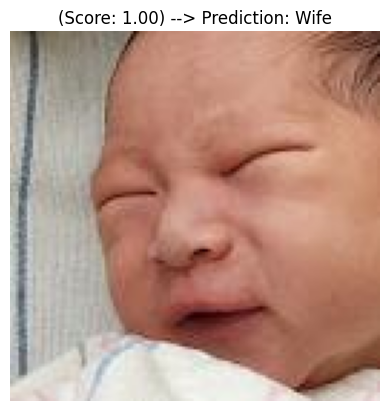

Button(description='Next', style=ButtonStyle())

In [18]:
# Prediction Function
def predict_image(image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_tensor = composer(img).unsqueeze(0).to(device)  # Move tensor to GPU
    with torch.no_grad():
        output = model(img_tensor)
        score = output.item()
        prediction = (output > 0.5).float()
        if prediction.item() == 1:
            return "Wife", score
        else:
            return "Husband", score

# Display Function
def display_image_and_prediction(image_path):
    img = Image.open(image_path)
    prediction, score = predict_image(image_path)
    plt.imshow(img)
    plt.title(f'(Score: {score:.2f}) --> Prediction: {prediction}')
    plt.axis('off')
    plt.show()

# Button Functionality
image_folder = 'baby'
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('png', 'jpg', 'jpeg'))]
current_index = 0

def on_next_button_clicked(b):
    global current_index
    if current_index < len(image_paths) - 1:
        current_index += 1
    else:
        current_index = 0
    clear_output(wait=True)
    display_image_and_prediction(image_paths[current_index])
    display(next_button)

next_button = widgets.Button(description="Next")
next_button.on_click(on_next_button_clicked)

# Initial Display
display_image_and_prediction(image_paths[current_index])
display(next_button)

## See the total score using all test images.

Okay, what is the total score? How many pictures the model predicts as "wife" and how many as "husband"?

In [17]:
# Initialize counters
wife_count = 0
husband_count = 0

# Iterate through all images and make predictions
for image_path in image_paths:
    prediction, score = predict_image(image_path)
    if prediction == "Wife":
        wife_count += 1
    else:
        husband_count += 1

# Print the results
print(f'Total images: {len(image_paths)}')
print(f'Predicted as Wife: {wife_count}')
print(f'Predicted as Husband: {husband_count}')

Total images: 242
Predicted as Wife: 237
Predicted as Husband: 5


Ooh... that's a hard pill to swallow. My model thinks my baby looks like my wife.

I guess I'll have to accept it. However, to get a little bit better understanding of what happened,

## Let's see the distribution of scores.

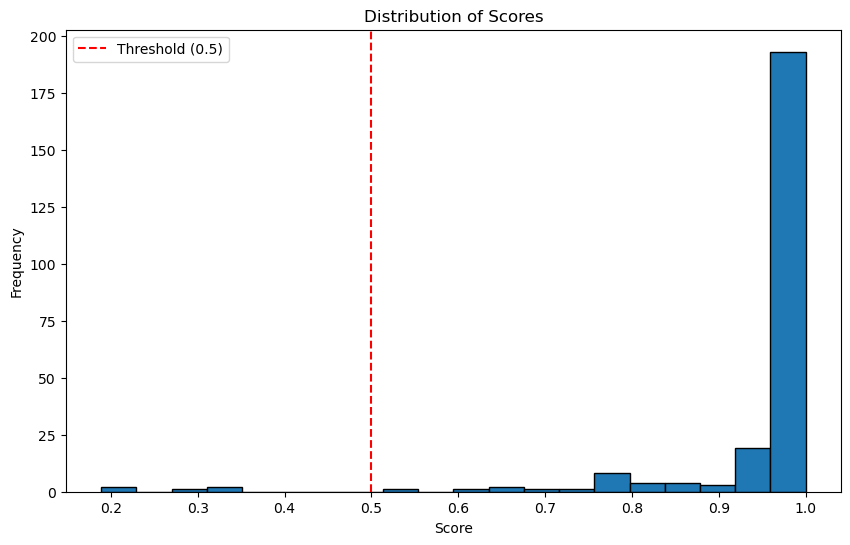

In [19]:
# Collect scores for all images
scores = []
for image_path in image_paths:
    _, score = predict_image(image_path)
    scores.append(score)

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.ylabel('Frequency')
plt.show()

It's definitely skewing towards my wife. Okay, I will accept.

# Step 3: See how the pictures cluster. - Using KMeans clustering.

In [23]:
# from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Define the transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset
test_dataset = ImageFolder(root='./test_data', transform=transform)
train_dataset = ImageFolder(root='./train_data', transform=transform)

# Combine datasets
combined_dataset = test_dataset + train_dataset
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

# Load a pre-trained ResNet model
# model = resnet50(pretrained=True)

model = model.eval()  # Set the model to evaluation mode

# Remove the final classification layer to get feature vectors
model = torch.nn.Sequential(*list(model.children())[:-1])

# Extract features
features = []
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)  # Move images to the same device as the model
        outputs = model(images).to(device)
        features.append(outputs.squeeze().cpu().numpy())

features = np.concatenate(features, axis=0)

# Reshape features to 2D array
features = features.reshape(features.shape[0], -1)



In [24]:
features.shape

(1397, 720000)

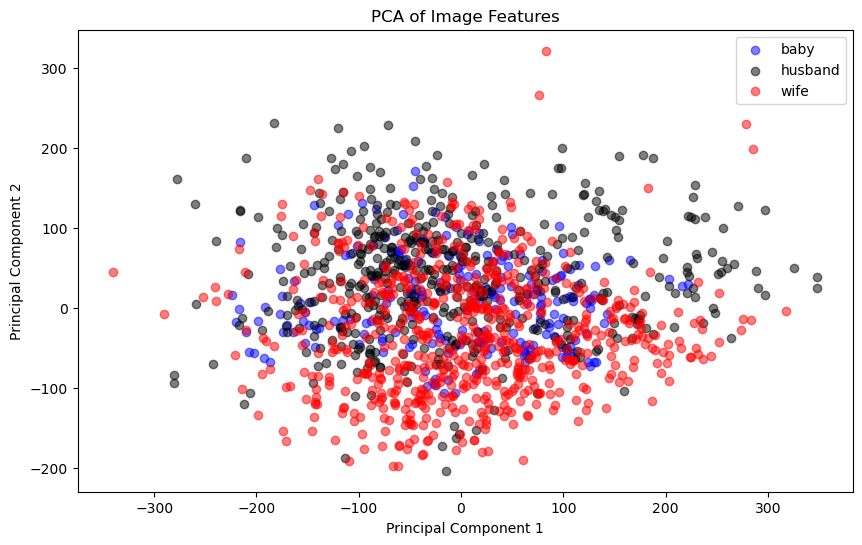

In [25]:

# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Create a color map for different categories
color_map = {
    'baby': 'blue',
    'husband': 'black',
    'wife': 'red'
}

# Extract labels and corresponding colors
labels = []
colors = []

# Iterate over each dataset in the ConcatDataset
for dataset in combined_dataset.datasets:
    for path, _ in dataset.imgs:
        if 'baby' in path:
            labels.append('baby')
            colors.append(color_map['baby'])
        elif 'husband' in path:
            labels.append('husband')
            colors.append(color_map['husband'])
        elif 'wife' in path:
            labels.append('wife')
            colors.append(color_map['wife'])

# Plot the PCA results
plt.figure(figsize=(10, 6))
for label in color_map.keys():
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(pca_features[indices, 0], pca_features[indices, 1], c=color_map[label], label=label, alpha=0.5)

plt.title('PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Observation

That does not cluster/separate the pictures by people. 
Let's try using a pre-trained resnet50.

In [21]:
from torchvision.models import resnet50, ResNet50_Weights

# Define the transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset
test_dataset = ImageFolder(root='./test_data', transform=transform)
train_dataset = ImageFolder(root='./train_data', transform=transform)

# Combine datasets
combined_dataset = test_dataset + train_dataset
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

# Load a pre-trained ResNet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model = model.eval()  # Set the model to evaluation mode

# Remove the final classification layer
model = torch.nn.Sequential(*list(model.children())[:-1])

# Extract features
features = []
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)  # Move images to the same device as the model
        outputs = model(images).to(device)
        features.append(outputs.squeeze().cpu().numpy())

features = np.concatenate(features, axis=0)

# Reshape features to 2D array
features = features.reshape(features.shape[0], -1)



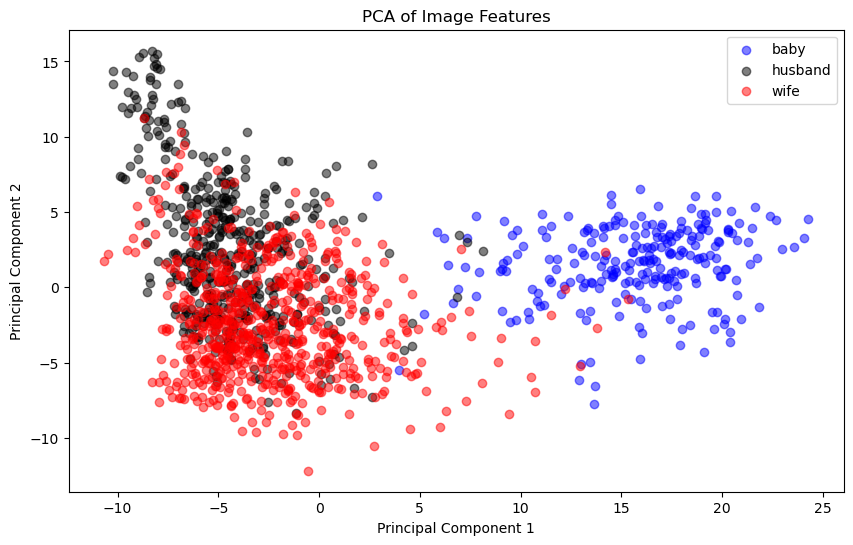

In [29]:

# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Create a color map for different categories
color_map = {
    'baby': 'blue',
    'husband': 'black',
    'wife': 'red'
}

# Extract labels and corresponding colors
labels = []
colors = []

# Iterate over each dataset in the ConcatDataset
for dataset in combined_dataset.datasets:
    for path, _ in dataset.imgs:
        if 'baby' in path:
            labels.append('baby')
            colors.append(color_map['baby'])
        elif 'husband' in path:
            labels.append('husband')
            colors.append(color_map['husband'])
        elif 'wife' in path:
            labels.append('wife')
            colors.append(color_map['wife'])

# Plot the PCA results
plt.figure(figsize=(10, 6))
for label in color_map.keys():
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(pca_features[indices, 0], pca_features[indices, 1], c=color_map[label], label=label, alpha=0.5)

plt.title('PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Observation 

Performaing PCA on ResNet50's feature space, We find that me and my wife's faces has much overlap, while the baby's faces is distanced from the two. 

Even though our baby's face is much separated, it seems difficult to "clearly" call who the baby resembles more (using resnet50, that is).

However, the average distance between my baby and my wife's faces seem smaller than the distance between me and my baby's.

Thus, I have no choice but to humbly accept that both my custom ML model and ResNet50 deems my baby resembles my wife more than me.

## Where do the baby's grandparents fall on the PCA plot?

For additional activity, let's mark the baby's gradparents' faces on the same plot (wife's dad, wife's mom, husband's dad, husband's mom).

The image files are located at ./other_data/w_dad, ./other_data/w_mom, ./other_data/h_dad, and ./other_data/h_mom.

In [22]:

mean, std = calculate_mean_std('./pca_data')

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset
pca_dataset = ImageFolder(root='./pca_data', transform=transform)
# pca_dataset = ImageFolder(root='./test_data', transform=transform)
# pca_dataset += ImageFolder(root='./train_data', transform=transform)
# pca_dataset += ImageFolder(root='./other_data', transform=transform)
dataloader = DataLoader(pca_dataset, batch_size=32, shuffle=False)

# Load a pre-trained ResNet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model = model.eval()  # Set the model to evaluation mode

# Remove the final classification layer to get feature vectors
model = torch.nn.Sequential(*list(model.children())[:-1])

# Extract features
features = []
with torch.no_grad():
    for images, _ in dataloader:
        outputs = model(images)
        features.append(outputs.squeeze().cpu().numpy())

features = np.concatenate(features, axis=0)

# Reshape features to 2D array
features = features.reshape(features.shape[0], -1)

# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)



# Example usage
data_paths = {
    'baby': './test_data/baby',
    'husband': './train_data/husband',
    'wife': './train_data/wife',
    'w_dad': './other_data/w_dad',
    'w_mom': './other_data/w_mom',
    'h_dad': './other_data/h_dad',
    'h_mom': './other_data/h_mom'
}

# Create a color map for different categories
color_map = {
    'baby': 'blue',
    'husband': 'black',
    'wife': 'red',
    'w_dad': 'orange',
    'w_mom': 'orangered',
    'h_dad': 'cyan',
    'h_mom': 'dodgerblue'
}

# Extract labels and corresponding colors
labels = []
colors = []

# Iterate over each dataset in the ConcatDataset
for label, _ in data_paths.items():
    dataset = ImageFolder(root='pca_data', transform=transform)
    for path, _ in dataset.imgs:

        if 'baby' in path:
            labels.append('baby')
            colors.append(color_map['baby'])
        elif 'husband' in path:
            labels.append('husband')
            colors.append(color_map['husband'])
        elif 'wife' in path:
            labels.append('wife')
            colors.append(color_map['wife'])
        elif 'h_dad' in path:
            labels.append('h_dad')
            colors.append(color_map['h_dad'])
        elif 'h_mom' in path:
            labels.append('h_mom')
            colors.append(color_map['h_mom'])
        elif 'w_dad' in path:
            labels.append('w_dad')
            colors.append(color_map['w_dad'])
        elif 'w_mom' in path:
            labels.append('w_mom')
            colors.append(color_map['w_mom'])

           

NameError: name 'PCA' is not defined

color_map.keys()=dict_keys(['baby', 'husband', 'wife', 'w_dad', 'w_mom', 'h_dad', 'h_mom'])


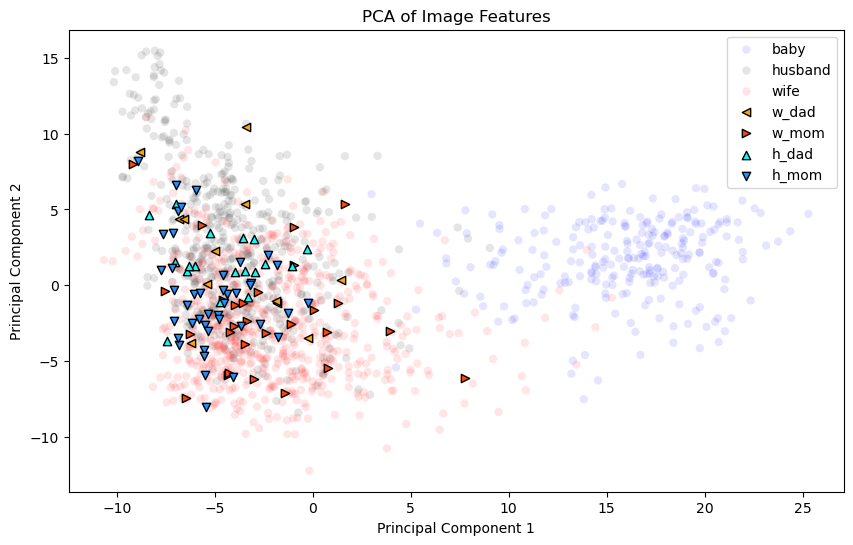

In [31]:


markers = {
    'baby': 'o',  # circle
    'husband': 'o', 
    'wife': 'o',  
    'w_dad': '<',  
    'w_mom': '>', 
    'h_dad': '^', 
    'h_mom': 'v'  
}

# Plot the PCA results
plt.figure(figsize=(10, 6))
print(f'{color_map.keys()=}')
for label in color_map.keys():
    indices = [i for i, l in enumerate(labels) if l == label]
    alpha = 0.1 if label in ['baby', 'husband', 'wife'] else 1.0
    # alpha = 1
    edgecolor = 'none' if label in ['baby', 'husband', 'wife'] else 'k'
    indices = [i for i in indices if i < 1498] # adhoc fix
    plt.scatter(pca_features[indices, 0], pca_features[indices, 1], c=color_map[label], label=label, alpha=alpha, edgecolors=edgecolor, marker=markers[label])

plt.title('PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## Observation 

It's not clear-cut, but the husband's mom and dad fall closer to the husband and the wife's mom and dad fall closer to the wife.

Is there a way to quantify this?

h_dad_to_husband: 5.64
h_mom_to_husband: 6.57
h_dad_to_wife: 6.82
h_mom_to_wife: 6.48
w_dad_to_wife: 7.84
w_mom_to_wife: 6.41
w_dad_to_husband: 6.71
w_mom_to_husband: 7.84


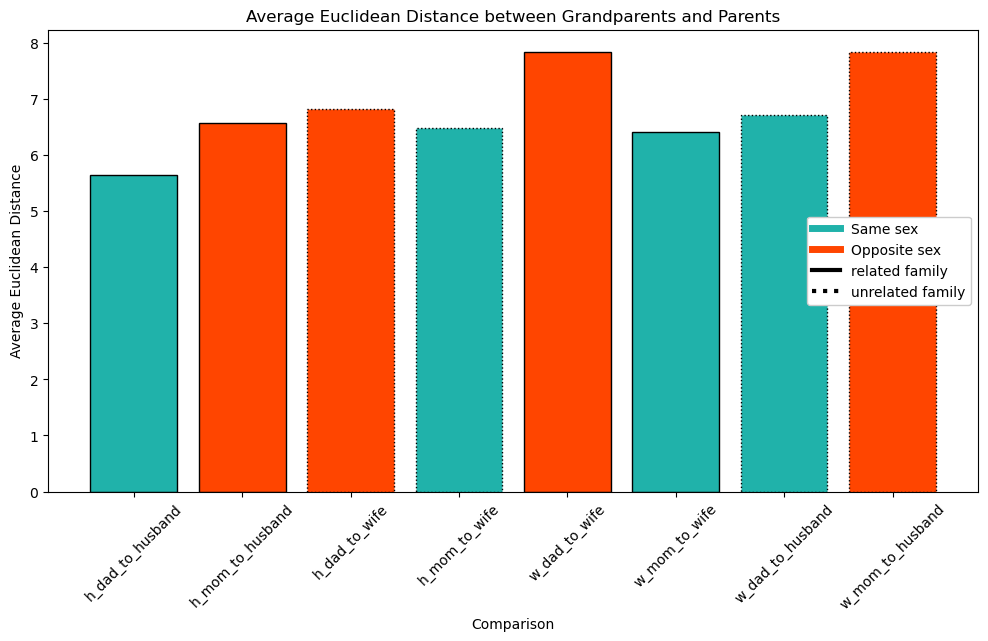

In [61]:
from scipy.spatial.distance import euclidean

# Function to calculate average Euclidean distance
def calculate_average_distance(label1, label2):
    indices1 = [i for i, l in enumerate(labels) if l == label1]
    indices1 = [i for i in indices1 if i < 1498] # adhoc fix
    indices2 = [i for i, l in enumerate(labels) if l == label2]
    indices2 = [i for i in indices2 if i < 1498] # adhoc fix
    distances = [euclidean(pca_features[i], pca_features[j]) for i in indices1 for j in indices2]
    return np.mean(distances)

# Calculate distances
distances = {}

distances['h_dad_to_husband'] = calculate_average_distance('h_dad', 'husband')
distances['h_mom_to_husband'] = calculate_average_distance('h_mom', 'husband')
distances['h_dad_to_wife'] = calculate_average_distance('h_dad', 'wife')
distances['h_mom_to_wife'] = calculate_average_distance('h_mom', 'wife')
distances['w_dad_to_wife'] = calculate_average_distance('w_dad', 'wife')
distances['w_mom_to_wife'] = calculate_average_distance('w_mom', 'wife')
distances['w_dad_to_husband'] = calculate_average_distance('w_dad', 'husband')
distances['w_mom_to_husband'] = calculate_average_distance('w_mom', 'husband')

# Print the results
for key, value in distances.items():
    print(f'{key}: {value:.2f}')

# Define textures for same sex and opposite sex
textures = {
    'same_sex': '//',  # diagonal lines
    'opposite_sex': 'xx'  # crosshatch
}

# Determine the texture for each bar
color_map = {}
outline_map = {}
for key in distances.keys():
    if 'h_dad' in key or 'h_mom' in key:
        if 'wife' in key:
            outline_map[key] = 'dotted'  # dotted outline means unrelated.
        else:
            outline_map[key] = 'solid'  # solid outline means related family.
    elif 'w_dad' in key or 'w_mom' in key:
        if 'husband' in key:
            outline_map[key] = 'dotted'  # dotted outline means unrelated.
        else:
            outline_map[key] = 'solid'  # solid outline means related family.

    if 'wife' in key:
        if 'h_mom' in key or 'w_mom' in key:
            color_map[key] = 'lightseagreen' # Lightseagreen means Same sex
        else:
            color_map[key] = 'orangered' # Orangered means Opposite sex
    elif 'husband' in key:
        if 'h_dad' in key or 'w_dad' in key:
            color_map[key] = 'lightseagreen' # Lightseagreen means Same sex
        else:
            color_map[key] = 'orangered' # Orangered means Opposite sex

# Plot the distances in a bar plot with textures
plt.figure(figsize=(12, 6))
bars = plt.bar(distances.keys(), distances.values(), color=[color_map[key] for key in distances.keys()], edgecolor='k')
for bar, key in zip(bars, distances.keys()):
    bar.set_linestyle(outline_map[key])

plt.xlabel('Comparison')
plt.ylabel('Average Euclidean Distance')
plt.title('Average Euclidean Distance between Grandparents and Parents')
plt.xticks(rotation=45)
# Add legend for textures
legend_elements = [
    plt.Line2D([0], [0], color='lightseagreen', lw=5, label='Same sex', alpha=1),
    plt.Line2D([0], [0], color='orangered', lw=5, label='Opposite sex', alpha=1),
    plt.Line2D([0], [0], color='black', lw=3, linestyle='solid', label="related family", alpha=1),
    plt.Line2D([0], [0], color='black', lw=3, linestyle='dotted', label="unrelated family", alpha=1)
]

plt.legend(handles=legend_elements, loc='center right', framealpha=1)

plt.show()

In [64]:
outline_map

{'h_dad_to_husband': 'solid',
 'h_mom_to_husband': 'solid',
 'h_dad_to_wife': 'dotted',
 'h_mom_to_wife': 'dotted',
 'w_dad_to_wife': 'solid',
 'w_mom_to_wife': 'solid',
 'w_dad_to_husband': 'dotted',
 'w_mom_to_husband': 'dotted'}

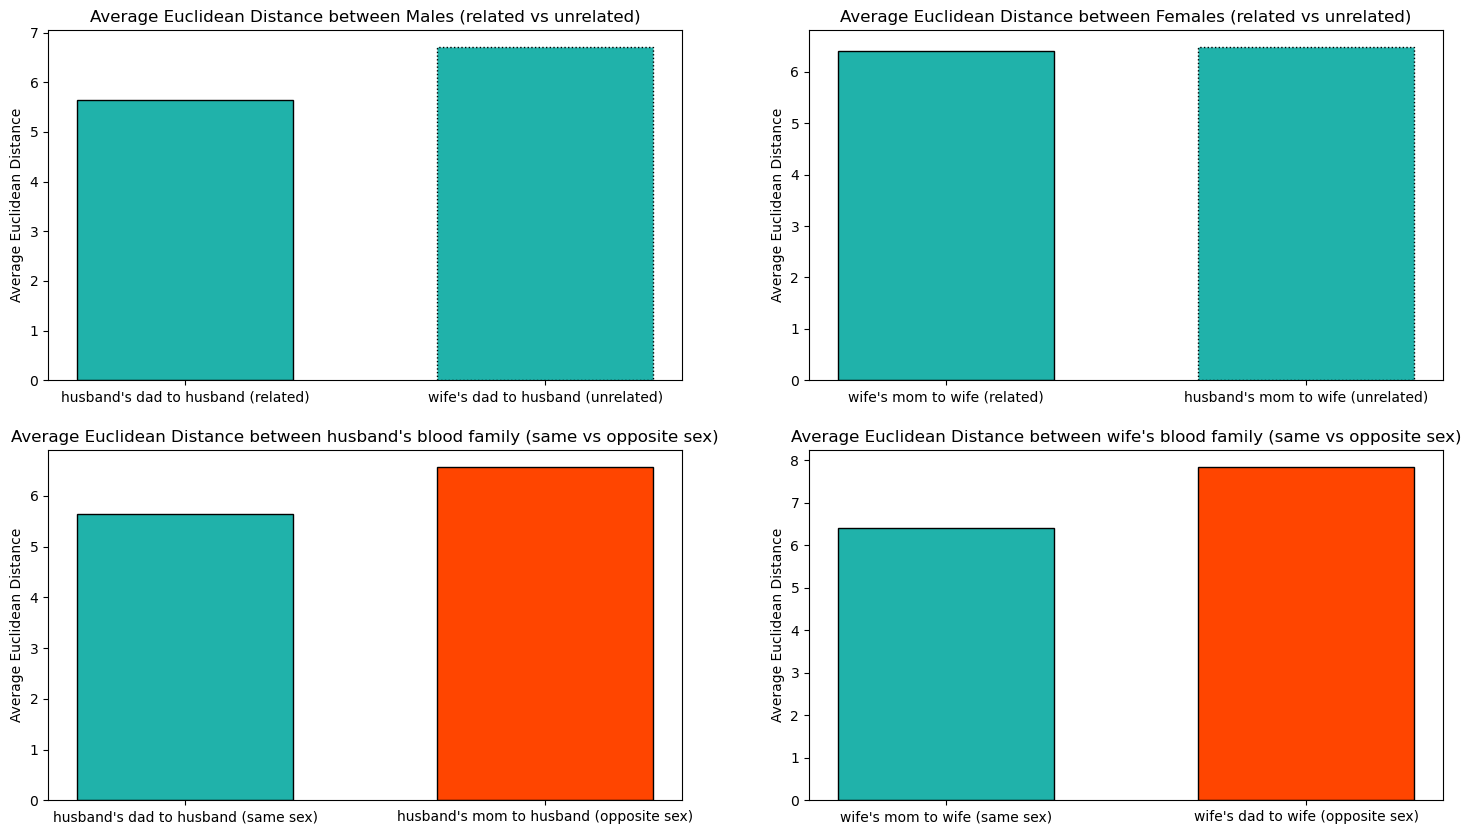

In [74]:
# Plot the distances in a bar plot
_, axs = plt.subplots(2, 2, figsize=(18, 10))
i = 0
axs = axs.flatten()

# Plot for Males (related vs unrelated)
ax = axs[i]
group = ['h_dad_to_husband', 'w_dad_to_husband']
bars = ax.bar(['husband\'s dad to husband (related)', 'wife\'s dad to husband (unrelated)'], 
              [distances[key] for key in group], 
              color=[color_map[key] for key in group], 
              edgecolor='k', 
              width=0.6)  # Adjust the width here
for bar, key in zip(bars, group):
    bar.set_linestyle(outline_map[key])

# Add labels and title
ax.set_ylabel('Average Euclidean Distance')
ax.set_title('Average Euclidean Distance between Males (related vs unrelated)')

# Plot for Females (related vs unrelated)
i += 1
ax = axs[i]
group = ['h_mom_to_wife', 'w_mom_to_wife'][::-1]
bars = ax.bar(['husband\'s mom to wife (unrelated)', 'wife\'s mom to wife (related)'][::-1], 
              [distances[key] for key in group], 
              color=[color_map[key] for key in group], 
              edgecolor='k', 
              width=0.6)  # Adjust the width here
for bar, key in zip(bars, group):
    bar.set_linestyle(outline_map[key])

# Add labels and title
ax.set_ylabel('Average Euclidean Distance')
ax.set_title('Average Euclidean Distance between Females (related vs unrelated)')

# Plot for husband's blood family (same vs opposite sex)
i += 1
ax = axs[i]
group = ['h_dad_to_husband', 'h_mom_to_husband']
bars = ax.bar(['husband\'s dad to husband (same sex)', 'husband\'s mom to husband (opposite sex)'], 
              [distances[key] for key in group], 
              color=[color_map[key] for key in group], 
              edgecolor='k', 
              width=0.6)  # Adjust the width here
for bar, key in zip(bars, group):
    bar.set_linestyle(outline_map[key])

# Add labels and title
ax.set_ylabel('Average Euclidean Distance')
ax.set_title('Average Euclidean Distance between husband\'s blood family (same vs opposite sex)')

# Plot for wife's blood family (same vs opposite sex)
i += 1
ax = axs[i]
group = ['w_mom_to_wife', 'w_dad_to_wife']
bars = ax.bar(['wife\'s mom to wife (same sex)', 'wife\'s dad to wife (opposite sex)'], 
              [distances[key] for key in group], 
              color=[color_map[key] for key in group], 
              edgecolor='k', 
              width=0.6)  # Adjust the width here
for bar, key in zip(bars, group):
    bar.set_linestyle(outline_map[key])

# Add labels and title
ax.set_ylabel('Average Euclidean Distance')
ax.set_title('Average Euclidean Distance between wife\'s blood family (same vs opposite sex)')

plt.show()

## Observation

The distance is shorter for the related than unrelated pairs,

and is shorter for the same sex than the opposite sex pairs.

Interesting!